In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

BASE_DIR = '../skins/'
RESULT_DIR = '../faces/'

## show mask and face

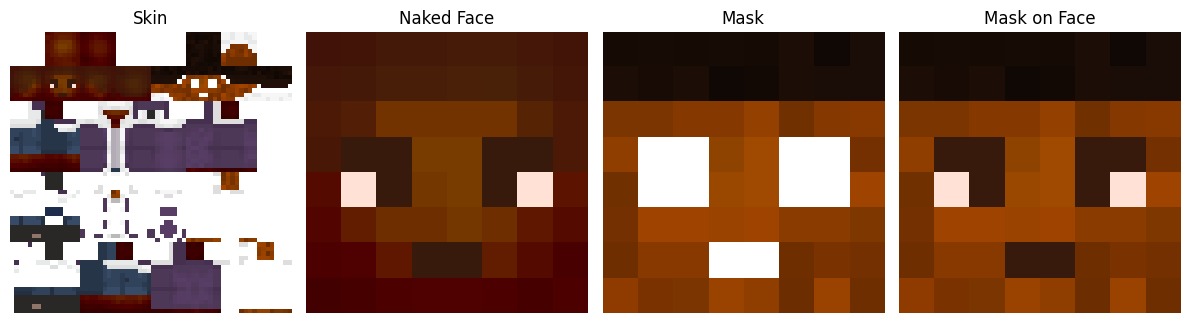

In [6]:
# source image: https://www.minecraftskins.com/skin/21856799/trial-boy/

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Create a figure and axis object
fig, axs = plt.subplots(1, 4, figsize=(12, 4))

skin = mpimg.imread("./trial-boy-21856799.png")

# skin image
axs[0].imshow(skin)
axs[0].set_title('Skin')
axs[0].axis('off')

# naked face
face = skin[8:16, 8:16]
axs[1].imshow(face)
axs[1].set_title('Naked Face')
axs[1].axis('off')

# mask
mask = skin[8:16, 40:48]
axs[2].imshow(mask)
axs[2].set_title('Mask')
axs[2].axis('off')

# mask on face
new_face = face.copy()
opacity = mask[:, :, 3]
non_zero_opacity_indices = np.where(opacity != 0)
new_face[non_zero_opacity_indices] = mask[non_zero_opacity_indices]
axs[3].imshow(new_face)
axs[3].set_title('Mask on Face')
axs[3].axis('off')

# adjust spacing between subplots
plt.tight_layout()

plt.show()

## cut out faces and put mask on

In [31]:
files = os.listdir(BASE_DIR)
files = sorted(files)

In [22]:
for file in files:
    skin = mpimg.imread(os.path.join(BASE_DIR, file))
    face = skin[8:16, 8:16]
    mask = skin[8:16, 40:48]

    non_zero_opacity_indices = np.where(mask[:, :, 3] != 0)
    face[non_zero_opacity_indices] = mask[non_zero_opacity_indices]
    mpimg.imsave(os.path.join(RESULT_DIR, file), face)

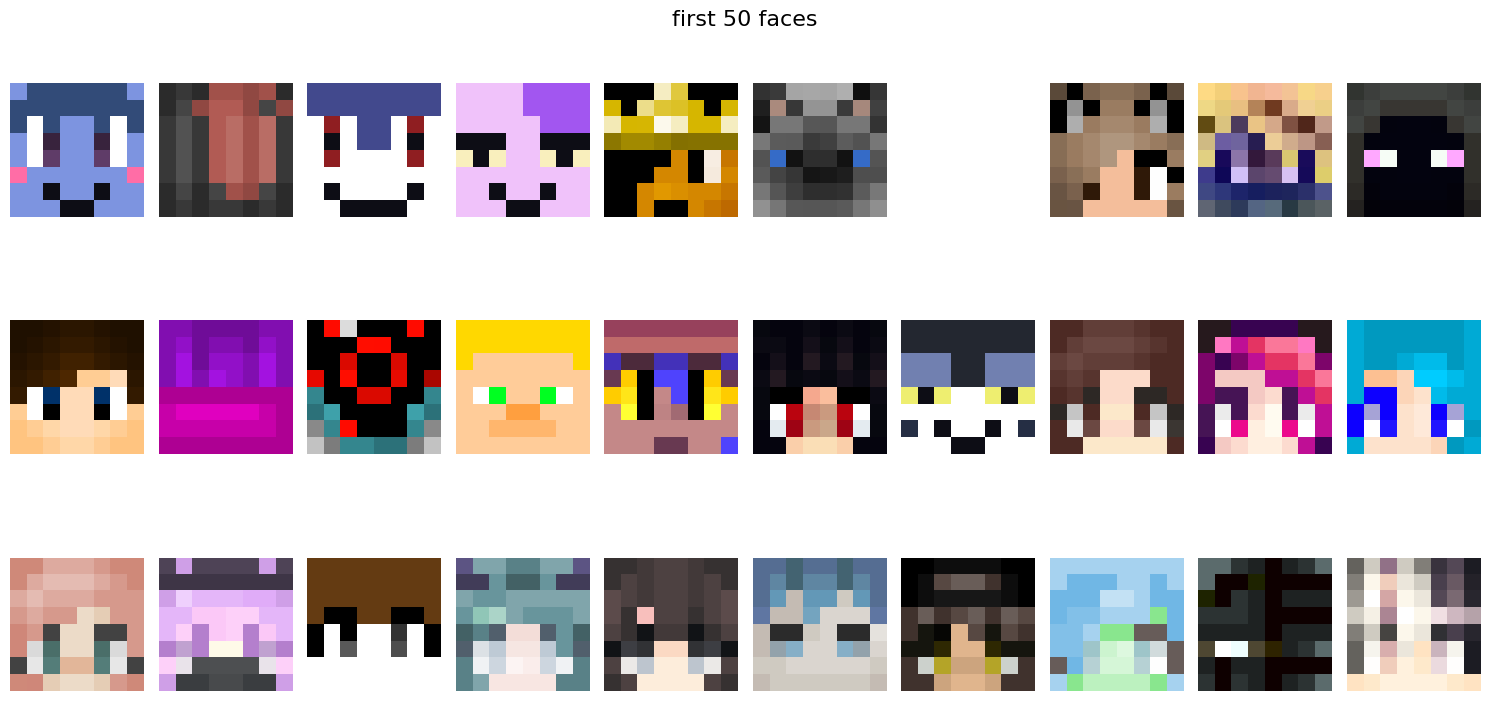

In [3]:
face_files = os.listdir(RESULT_DIR)
face_files = sorted(face_files)
fig, axs = plt.subplots(3, 10, figsize=(15, 8))
fig.suptitle('first 50 faces', fontsize=16)

for i, file in enumerate(face_files[0:30]):
    img = mpimg.imread(RESULT_DIR + file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    
plt.tight_layout()
plt.subplots_adjust(top=0.998)
plt.show()

## remove faces with insufficient color count

In [24]:
invalid_face_files = []
invalid_face_count = 0
for file in face_files:
    img = mpimg.imread(os.path.join(RESULT_DIR, file))
    if len(np.unique(img[:,:,:3])) < 3:
        invalid_face_files.append(file)
        invalid_face_count += 1

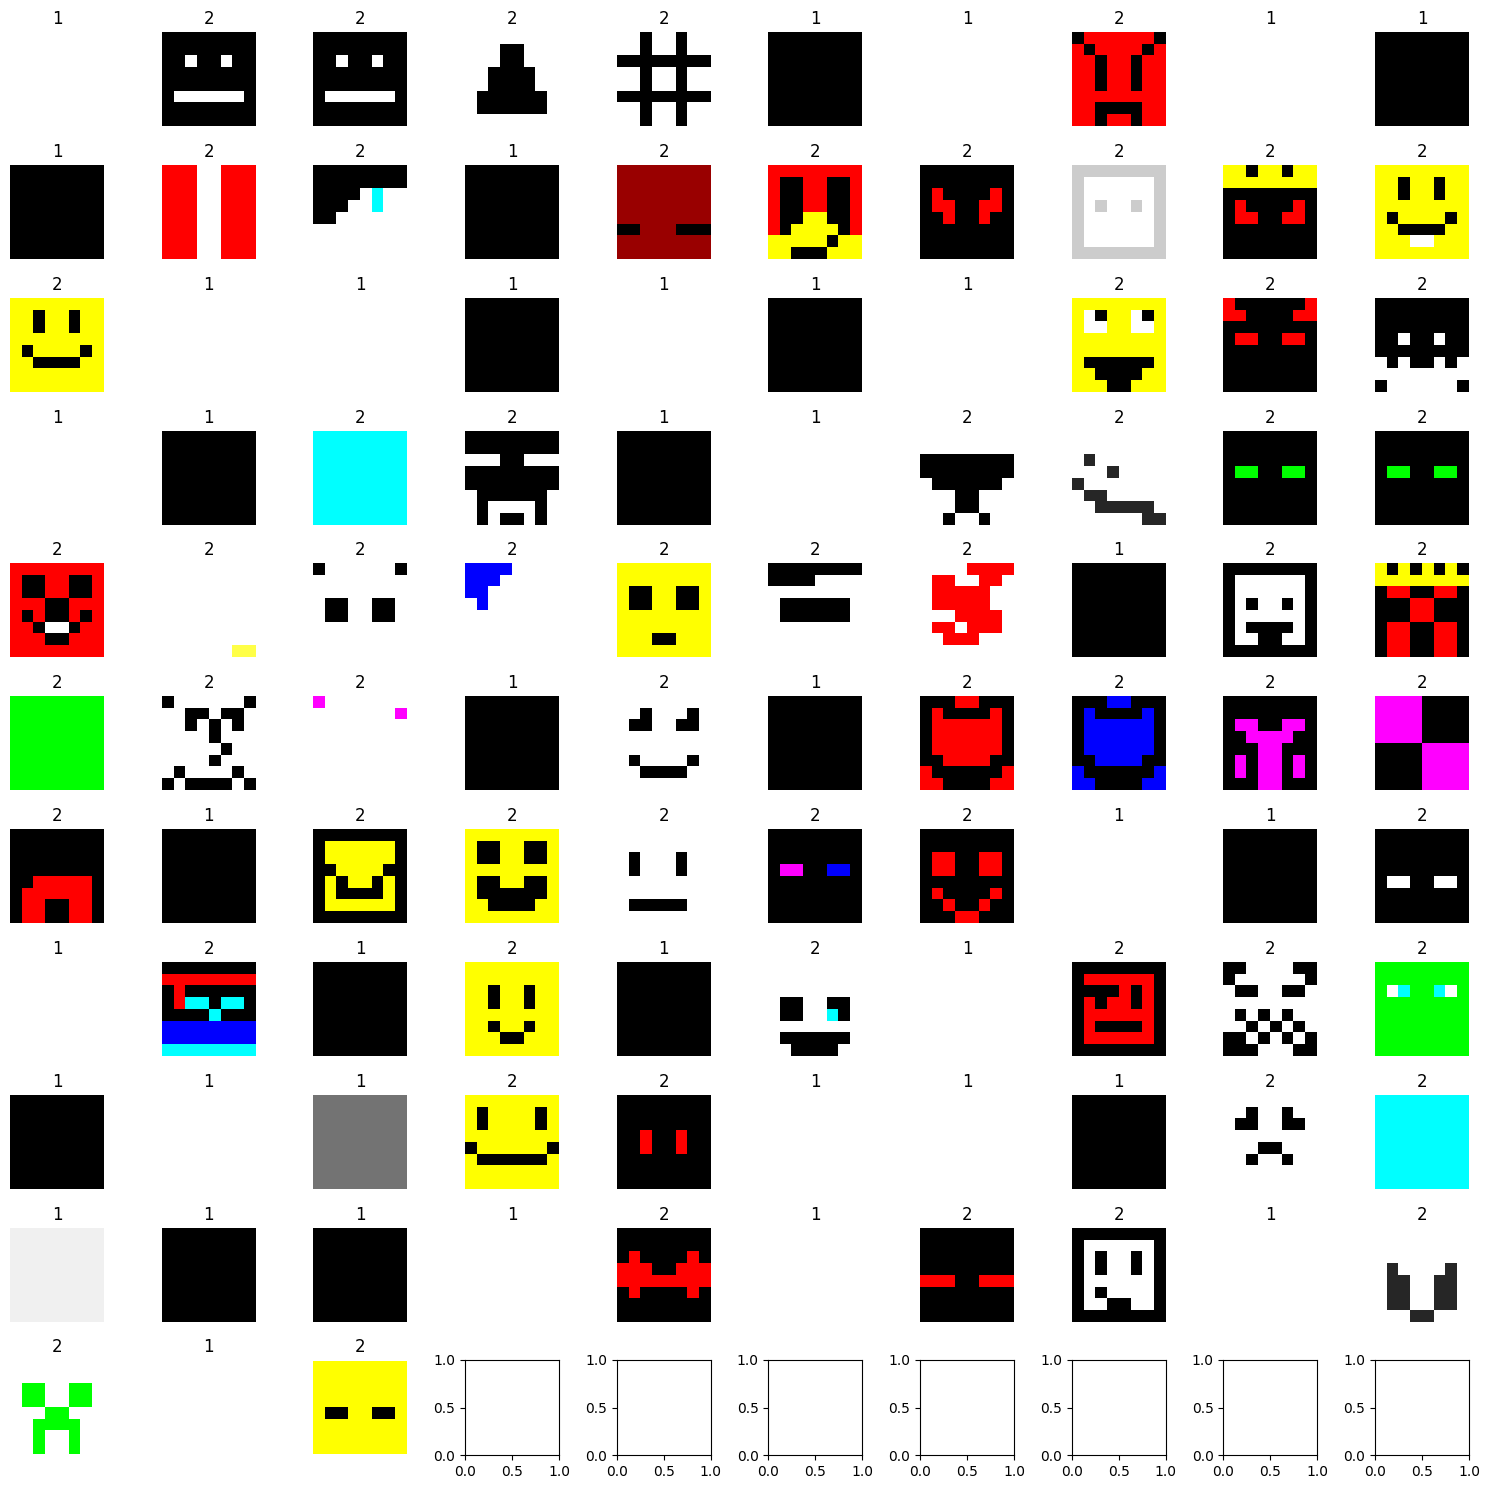

In [14]:
fig, axs = plt.subplots(invalid_face_count // 10 + 1, 10, figsize=(15, 15))

for i, file in enumerate(invalid_face_files):
    img = mpimg.imread(RESULT_DIR + file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')
    axs[i // 10, i % 10].set_title(str(len(np.unique(img[:,:,:3]))))
    
plt.tight_layout()
plt.show()

In [27]:
for file in invalid_face_files:
    os.remove(os.path.join(RESULT_DIR, file))

face_files = os.listdir(RESULT_DIR)
print(f'removed {invalid_face_count} invalid face images')

removed 113 invalid face images


## check symmetricity

In [46]:
symmetric_face_files = []
symmetric_count = 0
non_symmetric_count = 0

for file in face_files:
    face = mpimg.imread(os.path.join(RESULT_DIR, file))
    left = face[:,:4]
    right = face[:,4:]
    if not np.array_equal(left, np.flip(right, axis=1)):
        symmetric_face_files.append(file)
        non_symmetric_count += 1
    else:
        symmetric_count += 1

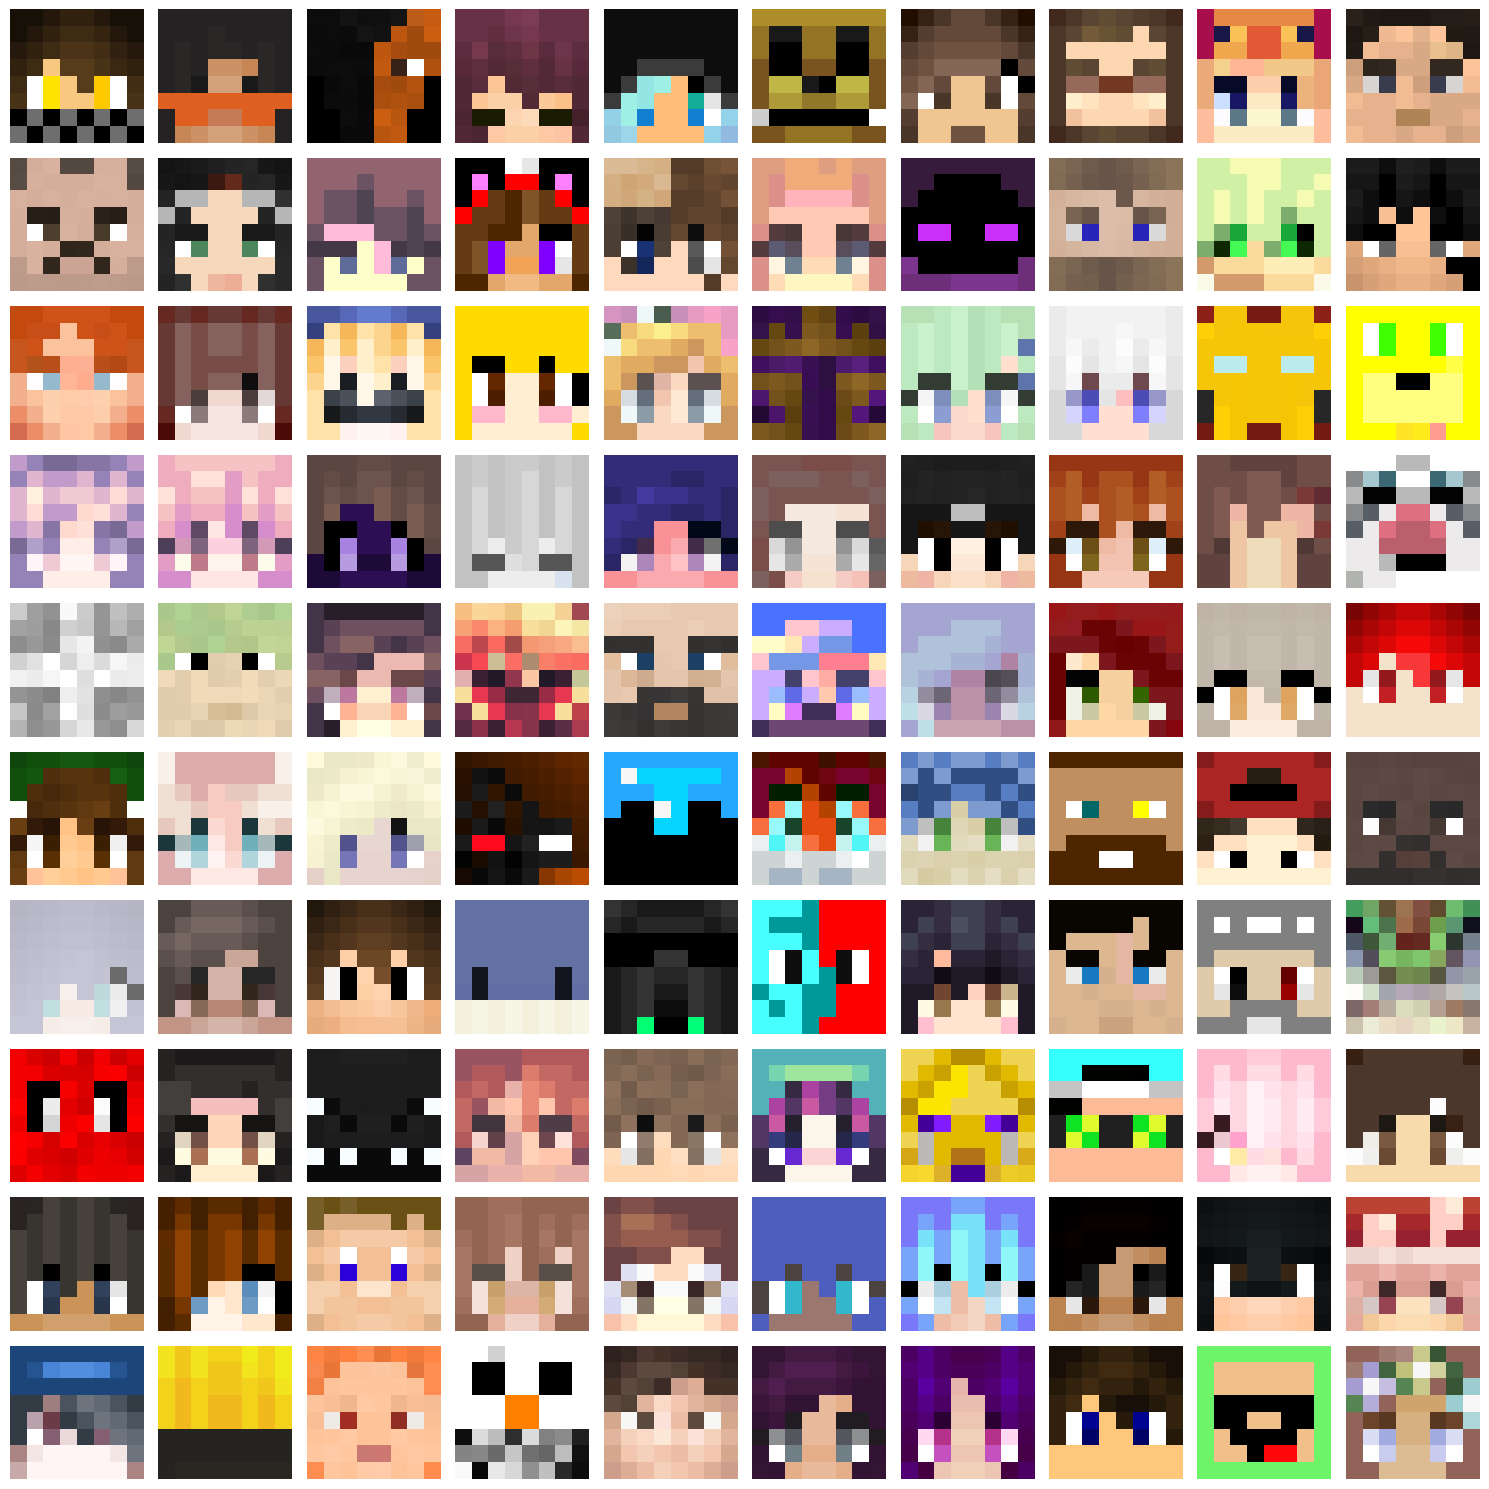

In [47]:
fig, axs = plt.subplots(10, 10, figsize=(15, 15))

for i, file in enumerate(symmetric_face_files[:100]):
    img = mpimg.imread(RESULT_DIR + file)
    axs[i // 10, i % 10].imshow(img)
    axs[i // 10, i % 10].axis('off')

    if (i + 1) % 100 == 0:
        plt.tight_layout()
        plt.show()
        input('enter')

## rename all files to zero-padded 5 digits

In [48]:
import os

files = os.listdir(RESULT_DIR)

for index, file_name in enumerate(files):
    new_file_name = "{:05d}".format(index + 1)
    
    file_path = os.path.join(RESULT_DIR, file_name)
    
    _, extension = os.path.splitext(file_name)
    
    new_file_path = os.path.join(RESULT_DIR, new_file_name + extension)
    
    os.rename(file_path, new_file_path)
